In [1]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from RecUnet_entangled import *
from train_RecUnet_all import *
%load_ext autoreload
%autoreload 2

#mlflow.autolog()

c:\Users\gaynuliy\Anaconda3\envs\home\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Test U-Net

In [2]:
data = dataset_seq()
loaders = get_loaders(data, 1)

In [11]:
args = {'lr' : 0.001, 'epochs' : 200, 'dev' : dev, 'name' : 'RecUnet_all'}
unet = RecUNet()
unet = load_network(unet, args['name']+'_4', args)

In [21]:
L_dam, L_shr, L_stiff = test(unet, loaders, args)
L_dam = np.array(L_dam)
L_shr = np.array(L_shr)
L_stiff = np.array(L_stiff)

In [22]:
dam_mean = np.mean(L_dam, axis=0)
dam_std = np.std(L_dam, axis=0)
shr_mean = np.mean(L_shr, axis=0)
shr_std = np.std(L_shr, axis=0)
stiff_mean = np.mean(L_stiff, axis=0)
stiff_std = np.std(L_stiff, axis=0)

Text(0, 0.5, 'Stiffness loss')

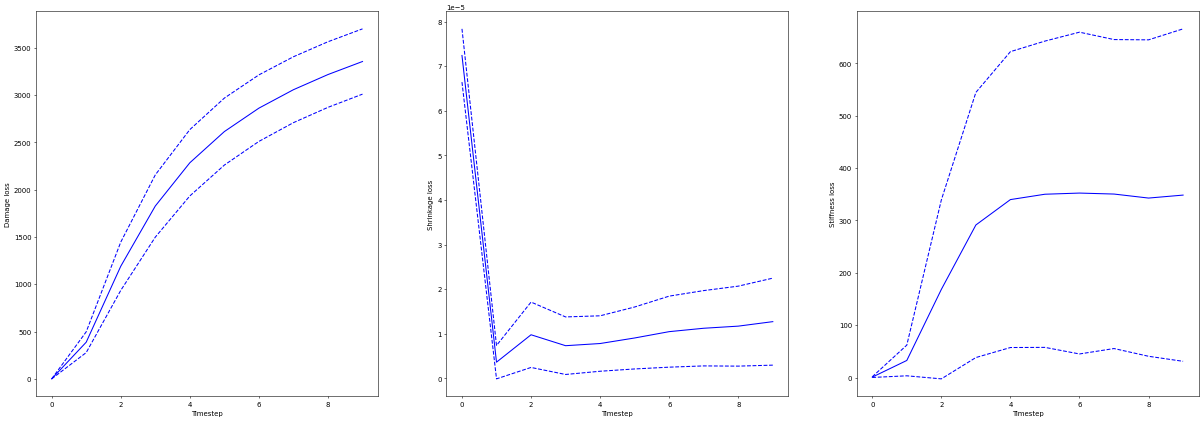

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=50)

axs.flat[0].plot(dam_mean, 'b')
axs.flat[0].plot(dam_mean+dam_std, 'b--')
axs.flat[0].plot(dam_mean-dam_std, 'b--')
axs.flat[0].set_xlabel('Timestep')
axs.flat[0].set_ylabel('Damage loss')

axs.flat[1].plot(shr_mean, 'b')
axs.flat[1].plot(shr_mean+shr_std, 'b--')
axs.flat[1].plot(shr_mean-shr_std, 'b--')
axs.flat[1].set_xlabel('Timestep')
axs.flat[1].set_ylabel('Shrinkage loss')

axs.flat[2].plot(stiff_mean, 'b')
axs.flat[2].plot(stiff_mean+stiff_std, 'b--')
axs.flat[2].plot(stiff_mean-stiff_std, 'b--')
axs.flat[2].set_xlabel('Timestep')
axs.flat[2].set_ylabel('Stiffness loss')

In [43]:
geometry, damage, imp_shrinkage, obs_shrinkage, stiffness = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])
stiffness = stiffness.to(args['dev'])

In [45]:
seq_test_dam = []
seq_test_shr = []
seq_test_stiff = []

for n in range(10):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:], 
                       1+damage[:,[n],:,:], 1+damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach().cpu())
    seq_test_shr.append(y[0,1].detach().cpu())
    seq_test_stiff.append(y[0,2].detach().cpu())

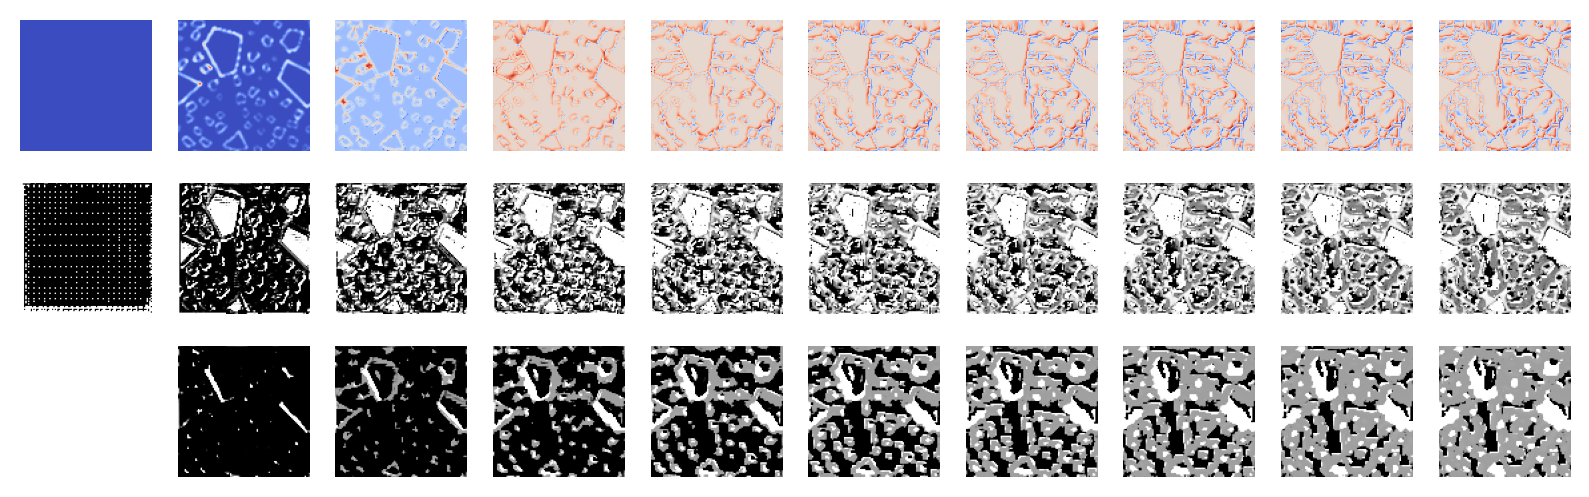

In [46]:
n_samples = 10
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples, 3), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i]-damage[0, i].cpu()).detach().cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-n_samples].cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(2*n_samples, 3*n_samples):
    axs.flat[i].imshow(seq_test_stiff[i-2*n_samples].cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()

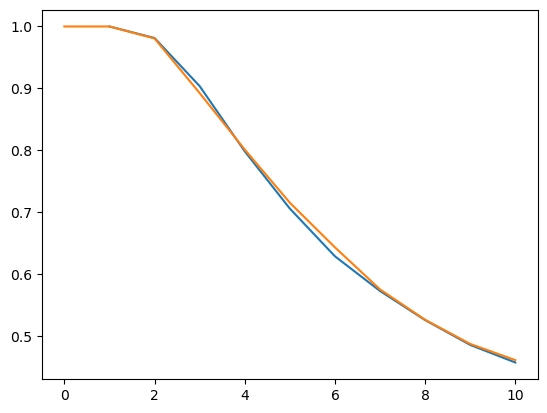

In [57]:
stiffness_mean = np.array([np.array(im) for im in seq_test_stiff])
plt.plot(np.arange(1,11),stiffness_mean.mean((1,2)))
plt.plot(stiffness[0].cpu() / stiffness[0,0].cpu())

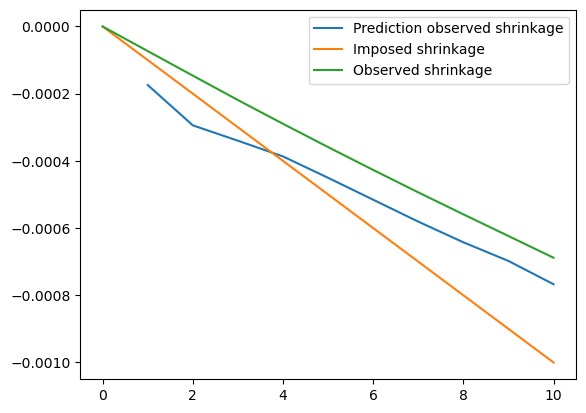

In [84]:
shr_mean = np.array([np.array(im) for im in seq_test_shr])
plt.plot(np.arange(1,11), (shr_mean * imp_shrinkage[:,1:,:,:].cpu().numpy()).mean((0,2,3)))
plt.plot(imp_shrinkage.cpu().numpy().mean((0,2,3)))
plt.plot(obs_shrinkage[0].cpu().numpy())
plt.legend(['Prediction observed shrinkage', 'Imposed shrinkage', 'Observed shrinkage'])

Extrapolate

In [10]:
for n in range(10):
    x = torch.cat([geometry, imp_shrinkage[:,[9],:,:] - (n+1)*1e-4, y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

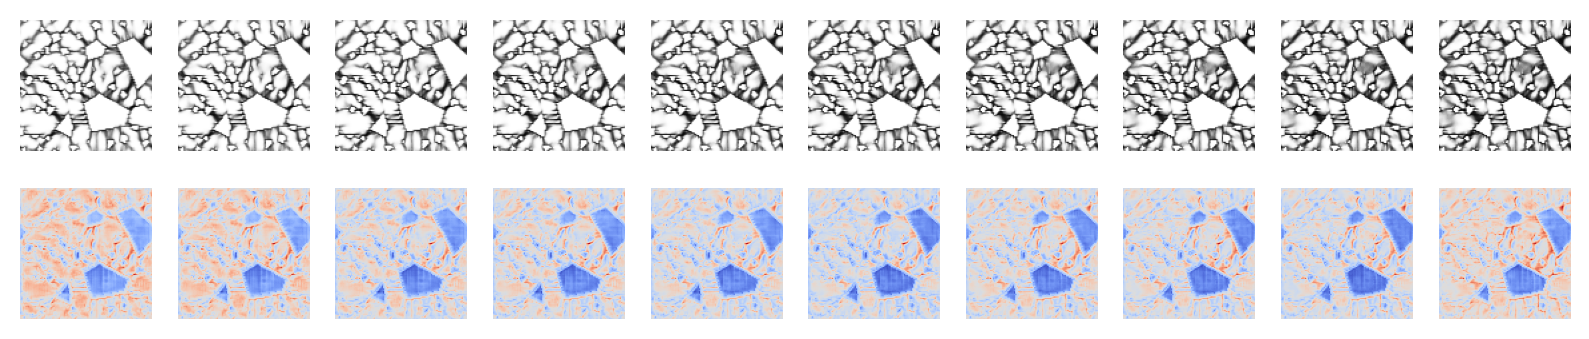

In [11]:
n_samples = 10
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i+n_samples]).detach().cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()

Skip

In [12]:
geometry, damage, imp_shrinkage, obs_shrinkage = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])

In [17]:
seq_test_dam = []
seq_test_shr = []

for n in range(0,10,3):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

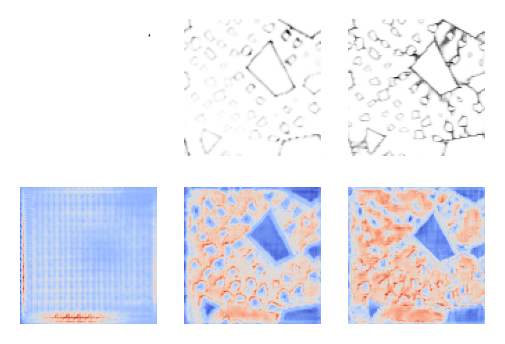

In [18]:
n_samples = 3
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i]).detach().cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-n_samples].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()